In [1]:
import spot
spot.setup()
from IPython.display import display

This notebook shows you different ways in which states or transitions can be highlighted in Spot.  

It should be noted that highlighting works using some special [named properties](https://spot.lrde.epita.fr/concepts.html#named-properties): basically, two maps that are attached to the automaton, and associated state or edge numbers to color numbers.  This named properties are fragile: they will be lost if the automaton is transformed into a new automaton, and they can become meaningless of the automaton is modified in place (e.g., if the transitions or states are reordered).

Nonetheless, highlighting is OK to use right before displaying or printing the automaton.  The `dot` and `hoa` printer both know how to represent highlighted states and transitions.

# Manual highlighting

In [2]:
a = spot.translate('a U b U c')

The `#` option of `print_dot()` can be used to display the internal number of each transition 

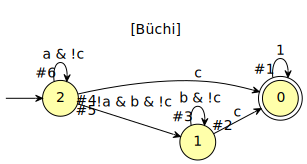

In [3]:
a.show('.#')

Using these numbers you can selectively hightlight some transitions.  The second argument is a color number (from a list of predefined colors).

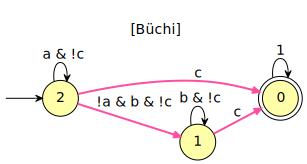

In [4]:
a.highlight_edges([2, 4, 5], 1)

Note that these `highlight_` functions work for edges and states, and come with both singular (changing the color of single state or edge) and plural versions.

They modify the automaton in place.

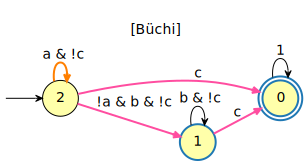

In [5]:
a.highlight_edge(6, 2).highlight_states((0, 1), 0)

The plural version can take a list or tuple of state numbers (as above) or of Booleans (as below).  In the latter case the indices of the True values give the states to highlight.

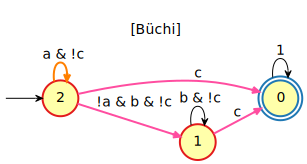

In [6]:
a.highlight_states([False, True, True], 5)

# Saving to HOA 1.1

When saving to HOA format, the highlighting is only output if version 1.1 of the format is selected, because the headers `spot.highlight.edges` and `spot.highlight.states` contain dots, which are disallowed in version 1.  Compare these two outputs:

In [7]:
print(a.to_str('HOA', '1'))
print()
print(a.to_str('HOA', '1.1'))

HOA: v1
States: 3
Start: 2
AP: 3 "a" "b" "c"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc deterministic
properties: stutter-invariant terminal
--BODY--
State: 0 {0}
[t] 0
State: 1
[2] 0
[1&!2] 1
State: 2
[2] 0
[!0&1&!2] 1
[0&!2] 2
--END--

HOA: v1.1
States: 3
Start: 2
AP: 3 "a" "b" "c"
acc-name: Buchi
Acceptance: 1 Inf(0)
properties: trans-labels explicit-labels state-acc !complete
properties: deterministic stutter-invariant terminal
spot.highlight.states: 0 0 1 5 2 5
spot.highlight.edges: 2 1 4 1 5 1 6 2
--BODY--
State: 0 {0}
[t] 0
State: 1
[2] 0
[1&!2] 1
State: 2
[2] 0
[!0&1&!2] 1
[0&!2] 2
--END--


# Highlighting a run

One use of this highlighting is to highlight a run in an automaton.

The following few command generate an automaton, then an accepting run on this automaton, and highlight that accepting run on the automaton.  Note that a run knows the automaton from which it was generated, so calling `highlight()` will directly decorate that automaton.

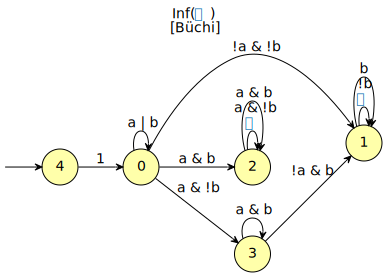

In [8]:
b = spot.translate('X (F(Ga <-> b) & GF!b)'); b

In [9]:
r = b.accepting_run(); r

Prefix:
  4
  |  1
  0
  |  !a & !b
Cycle:
  1
  |  !b	{0}

In [10]:
r.highlight(5) # the parameter is a color number

The call of `highlight(5)` on the accepting run `r` modified the original automaton `b`:

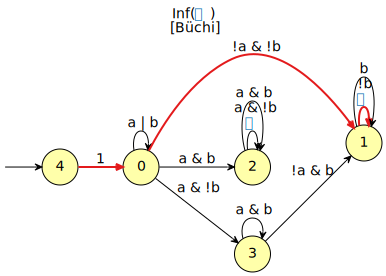

In [11]:
b

# Highlighting from a product

Pretty often, accepting runs are found in a product but we want to display them on one of the original automata.  This can be done by projecting the runs on those automata before displaying them.

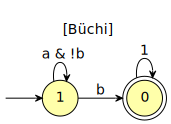

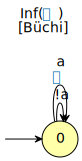

In [12]:
left = spot.translate('a U b')
right = spot.translate('GFa')
display(left, right)

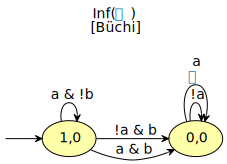

In [13]:
prod = spot.product(left, right); prod

In [14]:
run = prod.accepting_run(); run

Prefix:
  1,0
  |  !a & b
Cycle:
  0,0
  |  a	{0}

In [15]:
run.highlight(5)
# Note that by default project() needs to know on which side you project, but it cannot 
# guess it.  The left-side is assumed unless you pass True as a second argument.
run.project(left).highlight(5)
run.project(right, True).highlight(5)

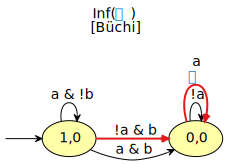

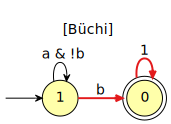

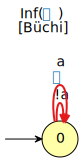

In [16]:
display(prod, left, right)

The projection also works for products generated on-the-fly, but the on-the-fly product itself cannot be highlighted (it does not store states or transitions). 

Prefix:
  0 * 3
  |  a & !b
  1 * 2
  |  a	{0}
  1 * 1
  |  a	{0}
  1 * 0
  |  a & b	{0}
Cycle:
  1 * 4
  |  a	{0,1}

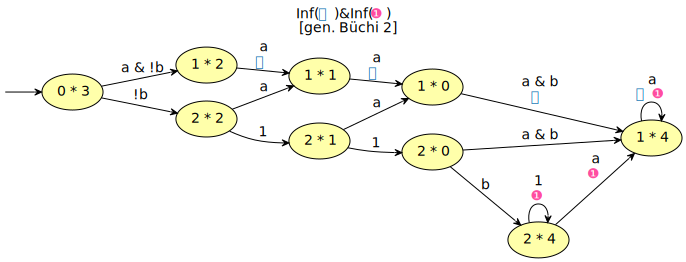

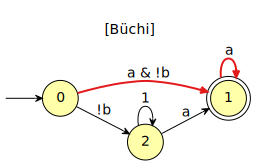

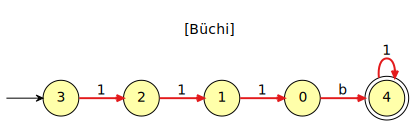

In [17]:
left2 = spot.translate('!b & FG a')
right2 = spot.translate('XXXb')
prod2 = spot.otf_product(left2, right2)  # Note "otf_product()"
run2 = prod2.accepting_run()
run2.project(left2).highlight(5)
run2.project(right2, True).highlight(5)
display(run2, prod2, left2, right2)

# Highlighting nondeterminism

Sometimes its is hard to locate non-deterministic states inside a large automaton.  Here are two functions that can help for that.

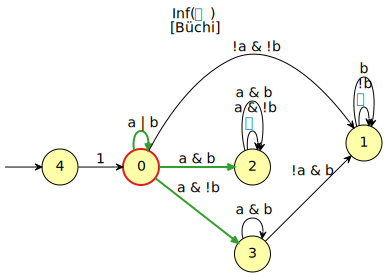

In [18]:
b = spot.translate('X (F(Ga <-> b) & GF!b)')
spot.highlight_nondet_states(b, 5)
spot.highlight_nondet_edges(b, 4)
b

# Disappearing highlights

As explained at the top of this notebook, named properties (such as highlights) are fragile, and you should not really on them being preserved across algorithms.  In-place algorithm are probably the worst, because they might modify the automaton and ignore the attached named properties.  

`randomize()` is one such in-place algorithm: it reorder states or transitions of the automaton.   By doing so it renumber the states and edges, and that process would completely invalidate the highlights information.  Fortunately `randomize()` know about highlights: it will preserve highlighted states, but it will drop all highlighted edges.

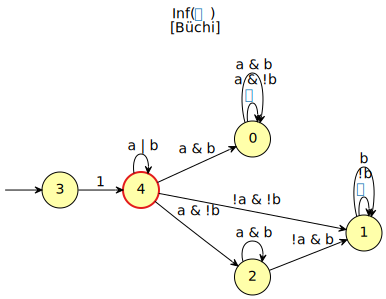

In [19]:
spot.randomize(b); b

# Highlighting with partial output

For simplicity, rendering of partial automata is actually implemented by copying the original automaton and marking some states as "incomplete".  This also allows the same display code to work with automata generated on-the-fly.  However since there is a copy, propagating the highlighting information requires extra work. Let's make sure it has been done:

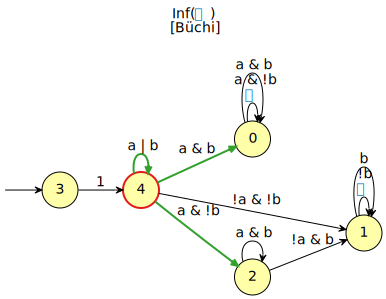

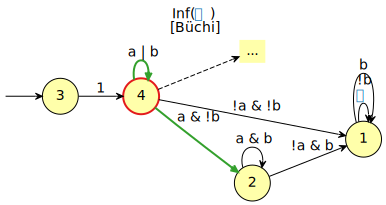

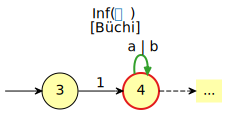

In [20]:
spot.highlight_nondet_edges(b, 4)  # let's get those highlighted edges back
display(b, b.show('.<4'), b.show('.<2'))

# Highlighting languages

For deterministic automata, the function `spot.highlight_languages()` can be used to highlight states that recognize the same language.  This can be a great help in reading automata.  States with a colored border share their language, and states with a black border all have a language different from all other states.

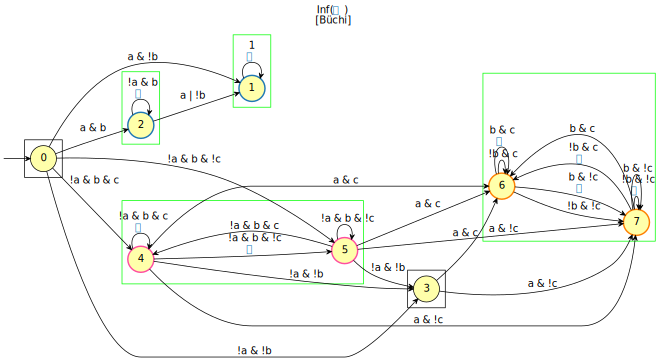

In [21]:
aut = spot.translate('(b W Xa) & GF(c <-> Xb) | a', 'generic', 'det')
spot.highlight_languages(aut)
aut.show('.bas')